In [104]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from collections import Counter


In [4]:
df_covid = pd.read_csv('covid19_tweets.csv', sep=',')

In [5]:
df_covid

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179103,AJIMATI AbdulRahman O.,"Ilorin, Nigeria",Animal Scientist|| Muslim|| Real Madrid/Chelsea,2013-12-30 18:59:19,412,1609,1062,False,2020-08-29 19:44:21,Thanks @IamOhmai for nominating me for the @WH...,['WearAMask'],Twitter for Android,False
179104,Jason,Ontario,When your cat has more baking soda than Ninja ...,2011-12-21 04:41:30,150,182,7295,False,2020-08-29 19:44:16,2020! The year of insanity! Lol! #COVID19 http...,['COVID19'],Twitter for Android,False
179105,BEEHEMOTH ⏳,🇨🇦 Canada,⚒️ The Architects of Free Trade ⚒️ Really Did ...,2016-07-13 17:21:59,1623,2160,98000,False,2020-08-29 19:44:15,@CTVNews A powerful painting by Juan Lucena. I...,NaN,Twitter Web App,False
179106,Gary DelPonte,New York City,"Global UX UI Visual Designer. StoryTeller, Mus...",2009-10-27 17:43:13,1338,1111,0,False,2020-08-29 19:44:14,"More than 1,200 students test positive for #CO...",['COVID19'],Twitter for iPhone,False


# Limpieza del dataset

Primero comprobamos que tipo de datos contiene el dataset

In [6]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         179108 non-null  object
 1   user_location     142337 non-null  object
 2   user_description  168822 non-null  object
 3   user_created      179108 non-null  object
 4   user_followers    179108 non-null  int64 
 5   user_friends      179108 non-null  int64 
 6   user_favourites   179108 non-null  int64 
 7   user_verified     179108 non-null  bool  
 8   date              179108 non-null  object
 9   text              179108 non-null  object
 10  hashtags          127774 non-null  object
 11  source            179031 non-null  object
 12  is_retweet        179108 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 15.4+ MB


Convertimos las fechas de cadena de caracteres al formato de fecha de Pandas

In [7]:
df_covid['date'] = pd.to_datetime(df_covid['date'])

Comprobamos si hay duplicados

In [8]:
duplicates = df_covid.duplicated()
if duplicates.any():
    print("True")
else:
    print("False")

False


Dependiendo del analisis que queramos hacer nos importarán más unos datos u otros. A mi no me interesan las columnas user_description, user_created, user_followers, user_friends, user_favorites, user_verified, source.<br>
Con los datos que nos quedan podriamos hacer un analisis geográfico con la location, o sobre el contenido de los tweets, también se podrían hacer cosas con la date e incluso hashtags.

In [9]:
df_covid2 = df_covid.drop(['user_name', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'source', 'is_retweet'], axis=1)


No hay duplicados, a continuación vemos si hay valores perdidos o faltantes

In [10]:
df_covid2.isna().sum()

user_location    36771
date                 0
text                 0
hashtags         51334
dtype: int64

In [11]:
df_covid2.shape

(179108, 4)

Si nos interesara analizar los hashtags, utilizariamos df_covid2, pero para seguir limpiando el dataset vamos a dropear todos datos nulos. Esto nos quita todos los tweets que no tengan hashtags y los cuales el usuario no tenga la location

In [12]:
df_covid2

,user_location,date,text,hashtags
0,astroworld,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN
1,"New York, NY",2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN
2,"Pewee Valley, KY",2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19']
3,Stuck in the Middle,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19']
4,Jammu and Kashmir,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']"
...,...,...,...,...
179103,"Ilorin, Nigeria",2020-08-29 19:44:21,Thanks @IamOhmai for nominating me for the @WH...,['WearAMask']
179104,Ontario,2020-08-29 19:44:16,2020! The year of insanity! Lol! #COVID19 http...,['COVID19']
179105,🇨🇦 Canada,2020-08-29 19:44:15,@CTVNews A powerful painting by Juan Lucena. I...,NaN
179106,New York City,2020-08-29 19:44:14,"More than 1,200 students test positive for #CO...",['COVID19']


In [13]:
df_covid3 = df_covid2.dropna()

In [14]:
df_covid3.shape

(101970, 4)

Nos hemos deshecho de aproximadamente 78.000 tweets

In [15]:
df_covid3

,user_location,date,text,hashtags
2,"Pewee Valley, KY",2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19']
3,Stuck in the Middle,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19']
4,Jammu and Kashmir,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']"
5,Новоро́ссия,2020-07-25 12:27:06,#coronavirus #covid19 deaths continue to rise....,"['coronavirus', 'covid19']"
6,"Gainesville, FL",2020-07-25 12:27:03,How #COVID19 Will Change Work in General (and ...,"['COVID19', 'Recruiting']"
...,...,...,...,...
179101,"Newton, NJ",2020-08-29 19:44:27,Wallkill school nurse adds COVID-19 monitoring...,"['nurses', 'COVID19', 'coronavirus', 'schools']"
179102,T.O.,2020-08-29 19:44:23,"we have reached 25mil cases of #covid19, world...",['covid19']
179103,"Ilorin, Nigeria",2020-08-29 19:44:21,Thanks @IamOhmai for nominating me for the @WH...,['WearAMask']
179104,Ontario,2020-08-29 19:44:16,2020! The year of insanity! Lol! #COVID19 http...,['COVID19']


In [16]:
df_covid3.isnull().values.any()

False

In [17]:
round(df_covid3.describe(), 2)

<ipython-input-17-9af97d95b078>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  round(df_covid3.describe(), 2)


,user_location,date,text,hashtags
count,101970,101970,101970,101970
unique,21296,85887,101767,42865
top,India,2020-07-29 16:00:00,In The Doom Days Of #COVID19 And Other Trouble...,['COVID19']
freq,2978,18,10,30903
first,NaN,2020-07-24 23:47:12,NaN,NaN
last,NaN,2020-08-30 09:07:34,NaN,NaN


In [18]:
df_covid3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101970 entries, 2 to 179106
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_location  101970 non-null  object        
 1   date           101970 non-null  datetime64[ns]
 2   text           101970 non-null  object        
 3   hashtags       101970 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 3.9+ MB


In [19]:
#Vamos a eliminar URLs, menciones, hashtags y caracteres especiales para simplificar el contenido del mensaje
def clean_tweet(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@[^\s]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'\W\s,¡!', '', text)
    return text

df_covid4 = df_covid3.copy()
df_covid4['text'] = df_covid4['text'].apply(clean_tweet)

In [20]:
df_covid4

,user_location,date,text,hashtags
2,"Pewee Valley, KY",2020-07-25 12:27:14,Trump never once claimed COVID19 was a hoax...,['COVID19']
3,Stuck in the Middle,2020-07-25 12:27:10,The one gift COVID19 has give me is an apprec...,['COVID19']
4,Jammu and Kashmir,2020-07-25 12:27:08,25 July : Media Bulletin on Novel CoronaVirusU...,"['CoronaVirusUpdates', 'COVID19']"
5,Новоро́ссия,2020-07-25 12:27:06,coronavirus covid19 deaths continue to rise. I...,"['coronavirus', 'covid19']"
6,"Gainesville, FL",2020-07-25 12:27:03,How COVID19 Will Change Work in General (and r...,"['COVID19', 'Recruiting']"
...,...,...,...,...
179101,"Newton, NJ",2020-08-29 19:44:27,Wallkill school nurse adds COVID-19 monitoring...,"['nurses', 'COVID19', 'coronavirus', 'schools']"
179102,T.O.,2020-08-29 19:44:23,"we have reached 25mil cases of covid19, worldw...",['covid19']
179103,"Ilorin, Nigeria",2020-08-29 19:44:21,Thanks for nominating me for the WearAMask c...,['WearAMask']
179104,Ontario,2020-08-29 19:44:16,2020! The year of insanity! Lol! COVID19,['COVID19']


# Análisis

Localización geográfica

In [36]:
tweet_location = df_covid4['user_location'].value_counts()
tweet_loc = tweet_location[:10]
tweet_loc

India               2978
United States       1795
New Delhi, India    1381
Mumbai, India       1110
Washington, DC       961
London, England      868
New York, NY         781
London               766
United Kingdom       727
New Delhi            680
Name: user_location, dtype: int64

Estas son las localizacones con mas tweets, el problema es que tenemos por un lado USA y por otro tenemos estados de USA que están separados, como si no fueran parte de USA. Asi que tenemos que juntar varios de estos datos

<Axes: xlabel='Location', ylabel='counts'>

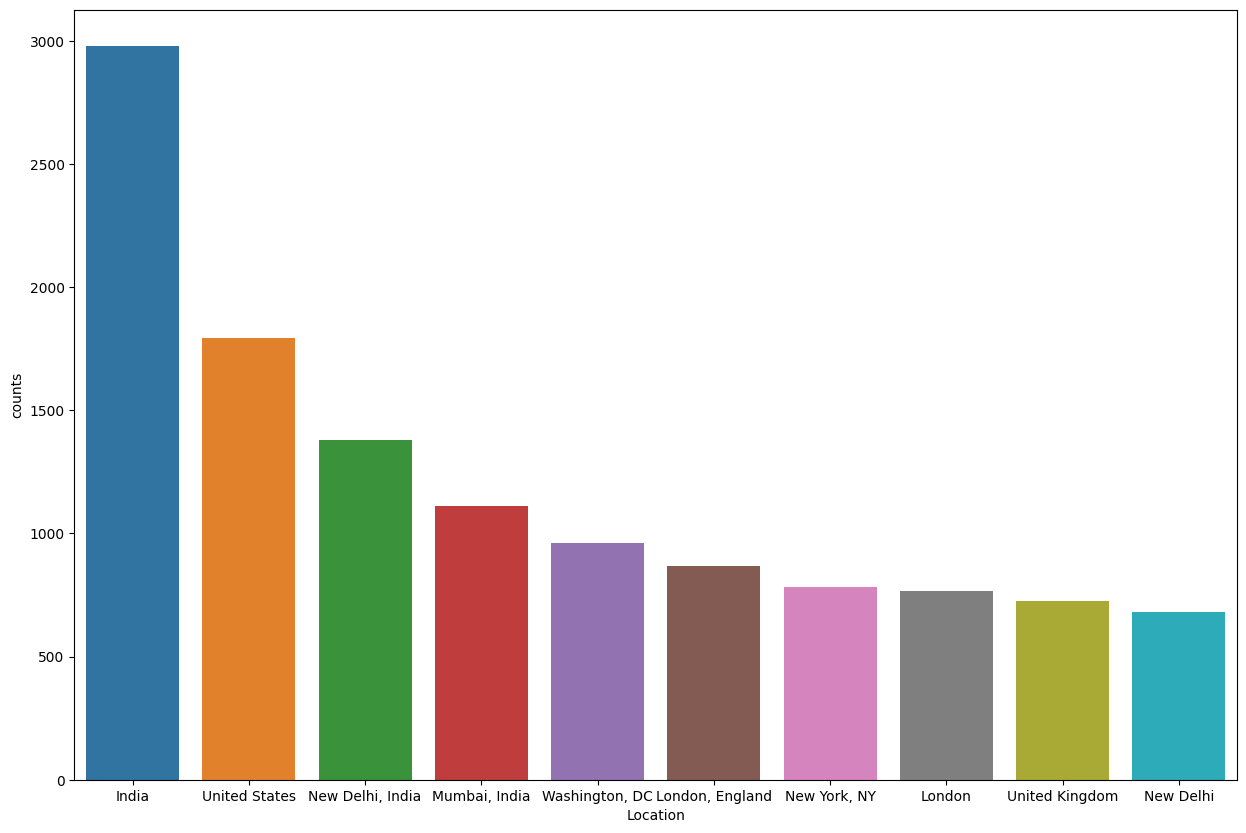

In [37]:
plt.figure(figsize = (15,10))
sns.barplot(x = tw_loc.Location,y = tw_loc.counts, data = tw_loc)

Hastag count

In [62]:
hashtags = df_covid4['hashtags'].explode().tolist()
top_hashtags = Counter(hashtags).most_common(10)
df_top_hashtags = pd.DataFrame(top_hashtags, columns=['Hashtag', 'Frecuencia'])

print(df_top_hashtags)


                             Hashtag  Frecuencia
0                        ['COVID19']       30903
1                        ['Covid19']        3925
2                        ['covid19']        2459
3                    ['coronavirus']         450
4         ['COVID19', 'coronavirus']         419
5         ['coronavirus', 'COVID19']         396
6         ['Coronavirus', 'COVID19']         271
7  ['CoronaVirusUpdates', 'COVID19']         246
8                    ['Coronavirus']         232
9               ['India', 'COVID19']         147


Text(0.5, 1.0, 'Top 10 Hashtags en Twitter')

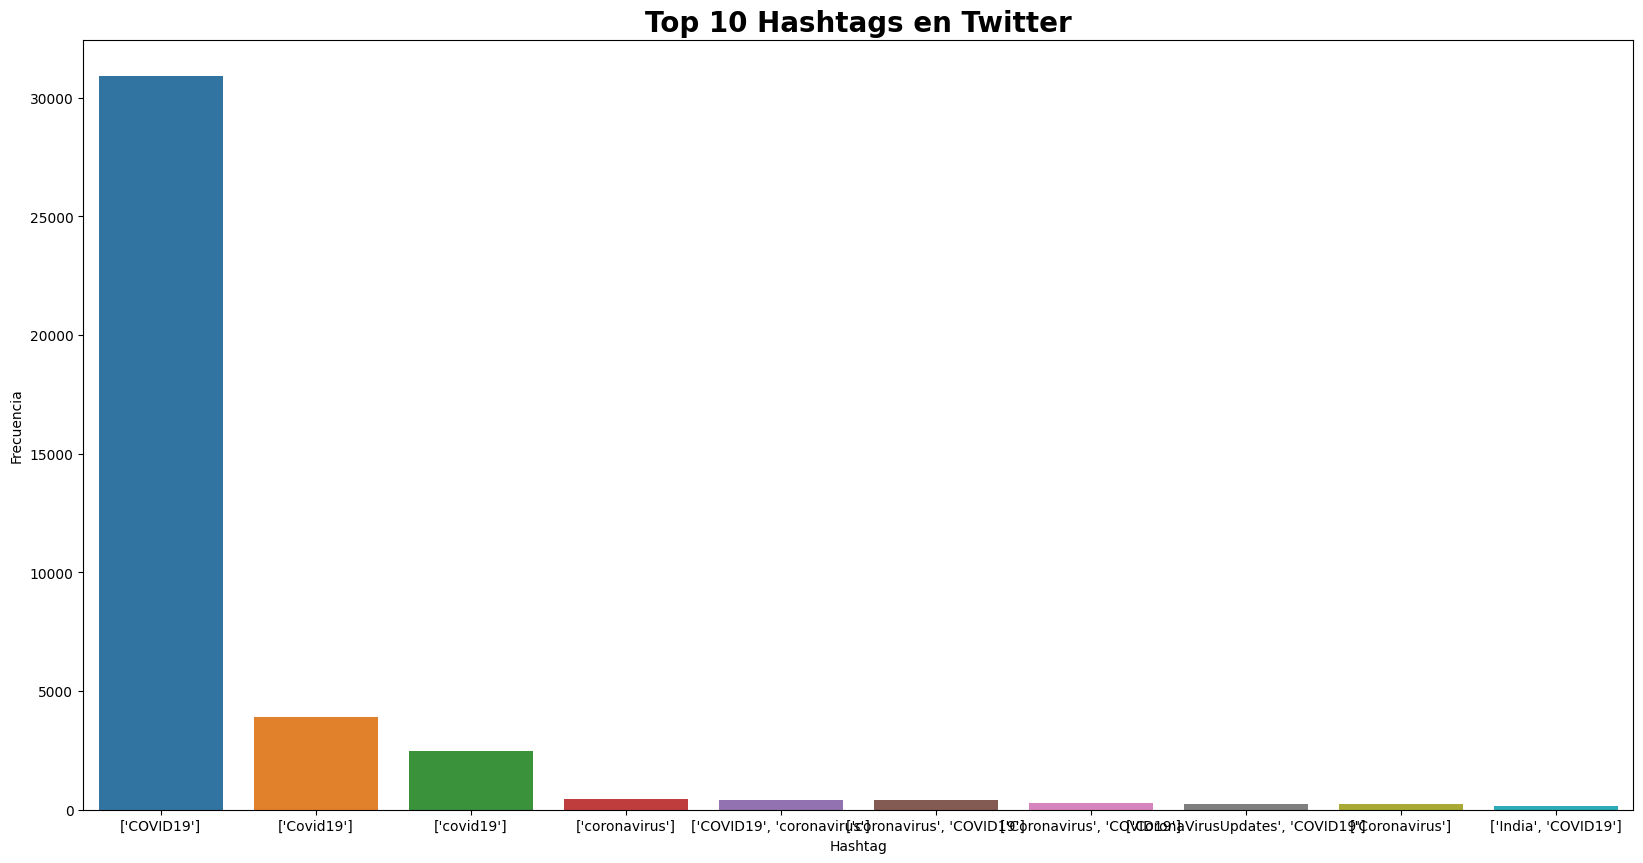

In [106]:
plt.figure(figsize = (20,10))
sns.barplot(x = df_top_hashtags.Hashtag, y = df_top_hashtags.Frecuencia, data = df_top_hashtags)
plt.title('Top 10 Hashtags en Twitter', fontweight = 'bold', fontsize='20')

Date analysis

In [38]:
df_date= df_covid4.copy()
df_date['date'].value_counts()

2020-07-29 16:00:00    18
2020-08-06 16:00:00    18
2020-08-04 07:00:00    17
2020-07-29 16:30:00    16
2020-08-10 15:30:00    16
                       ..
2020-08-02 18:21:56     1
2020-08-02 18:21:58     1
2020-08-02 18:22:16     1
2020-08-02 18:22:22     1
2020-08-29 19:44:14     1
Name: date, Length: 85887, dtype: int64

In [43]:
df_grouped = df_covid4.groupby(pd.Grouper(key='date', freq='D')).size().reset_index(name='count')

In [47]:
df_covid4['date'] = pd.to_datetime(df_covid4['date'])
df_covid4['date'].dt.date

2         2020-07-25
3         2020-07-25
4         2020-07-25
5         2020-07-25
6         2020-07-25
             ...    
179101    2020-08-29
179102    2020-08-29
179103    2020-08-29
179104    2020-08-29
179106    2020-08-29
Name: date, Length: 101970, dtype: object

In [51]:
df_tweets_por_dia = df_covid4.groupby(df_covid3['date'].dt.date)['text'].count()
df_tweets_por_dia = pd.DataFrame({'fecha': df_tweets_por_dia.index, 'tweets': df_tweets_por_dia.values})

print(df_tweets_por_dia)

         fecha  tweets
0   2020-07-24     160
1   2020-07-25    9535
2   2020-07-26    4402
3   2020-07-27    4309
4   2020-07-28    4241
5   2020-07-29    1574
6   2020-07-30    1093
7   2020-07-31    4295
8   2020-08-01    4308
9   2020-08-02    4131
10  2020-08-04    4344
11  2020-08-06    4221
12  2020-08-07     585
13  2020-08-08    4213
14  2020-08-09    4407
15  2020-08-10    2716
16  2020-08-11    4350
17  2020-08-12    4320
18  2020-08-13    4270
19  2020-08-14    4247
20  2020-08-16    4263
21  2020-08-17    4347
22  2020-08-18    4215
23  2020-08-22    6569
24  2020-08-29    2184
25  2020-08-30    4671


Text(0.5, 1.0, 'Numero de Tweets por dia')

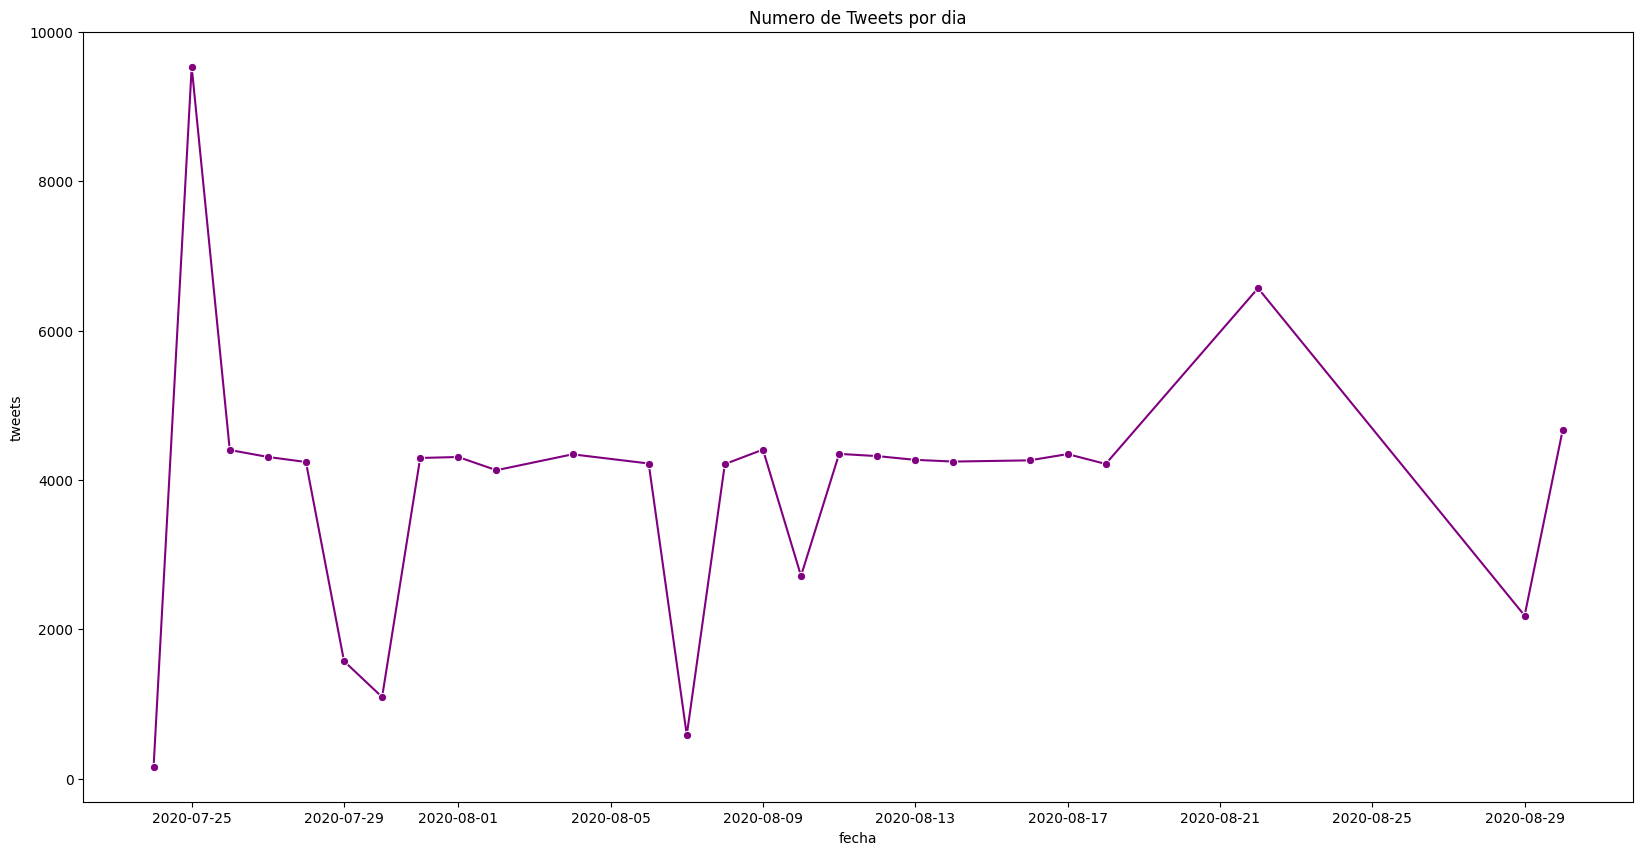

In [54]:
plt.figure(figsize = (20,10))
sns.lineplot(x =df_tweets_por_dia.fecha, y = df_tweets_por_dia.tweets, color = 'purple', marker = 'o')
plt.title('Numero de Tweets por dia')